##Load Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


In [26]:

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

##Load the Dataset

In [27]:
df = pd.read_csv("/content/climate_change_dataset.csv")
df.head()


,Year,Country,Avg Temperature (°C),CO2 Emissions (Tons/Capita),Sea Level Rise (mm),Rainfall (mm),Population,Renewable Energy (%),Extreme Weather Events,Forest Area (%)
0,2006,UK,8.9,9.3,3.1,1441,530911230,20.4,14,59.8
1,2019,USA,31.0,4.8,4.2,2407,107364344,49.2,8,31.0
2,2014,France,33.9,2.8,2.2,1241,441101758,33.3,9,35.5
3,2010,Argentina,5.9,1.8,3.2,1892,1069669579,23.7,7,17.7
4,2007,Germany,26.9,5.6,2.4,1743,124079175,12.5,4,17.4


##Data exploration and visualization

In [28]:
#  Descriptive Statistics
print("Basic Info:")
print(df.info())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         1000 non-null   int64  
 1   Country                      1000 non-null   object 
 2   Avg Temperature (°C)         1000 non-null   float64
 3   CO2 Emissions (Tons/Capita)  1000 non-null   float64
 4   Sea Level Rise (mm)          1000 non-null   float64
 5   Rainfall (mm)                1000 non-null   int64  
 6   Population                   1000 non-null   int64  
 7   Renewable Energy (%)         1000 non-null   float64
 8   Extreme Weather Events       1000 non-null   int64  
 9   Forest Area (%)              1000 non-null   float64
dtypes: float64(5), int64(4), object(1)
memory usage: 78.3+ KB
None


In [29]:
print("\nSummary Statistics:")
print(df.describe(include='all'))


Summary Statistics:
               Year    Country  Avg Temperature (°C)  \
count   1000.000000       1000           1000.000000   
unique          NaN         15                   NaN   
top             NaN  Indonesia                   NaN   
freq            NaN         75                   NaN   
mean    2011.432000        NaN             19.883100   
std        7.147199        NaN              8.542897   
min     2000.000000        NaN              5.000000   
25%     2005.000000        NaN             12.175000   
50%     2012.000000        NaN             20.100000   
75%     2018.000000        NaN             27.225000   
max     2023.000000        NaN             34.900000   

        CO2 Emissions (Tons/Capita)  Sea Level Rise (mm)  Rainfall (mm)  \
count                   1000.000000          1000.000000    1000.000000   
unique                          NaN                  NaN            NaN   
top                             NaN                  NaN            NaN   
freq  

In [30]:
# Initial exploration
print("Dataset shape:", df.shape)
print("\nDataset columns:\n", df.columns)
print("\nMissing values per column:\n", df.isnull().sum())




Dataset shape: (1000, 10)

Dataset columns:
 Index(['Year', 'Country', 'Avg Temperature (°C)',
       'CO2 Emissions (Tons/Capita)', 'Sea Level Rise (mm)', 'Rainfall (mm)',
       'Population', 'Renewable Energy (%)', 'Extreme Weather Events',
       'Forest Area (%)'],
      dtype='object')

Missing values per column:
 Year                           0
Country                        0
Avg Temperature (°C)           0
CO2 Emissions (Tons/Capita)    0
Sea Level Rise (mm)            0
Rainfall (mm)                  0
Population                     0
Renewable Energy (%)           0
Extreme Weather Events         0
Forest Area (%)                0
dtype: int64


In [31]:
# Drop rows with missing values (if not too many)
df.dropna(inplace=True)

In [32]:
# Select only numeric columns for correlation
numeric_data = df.select_dtypes(include=[np.number])

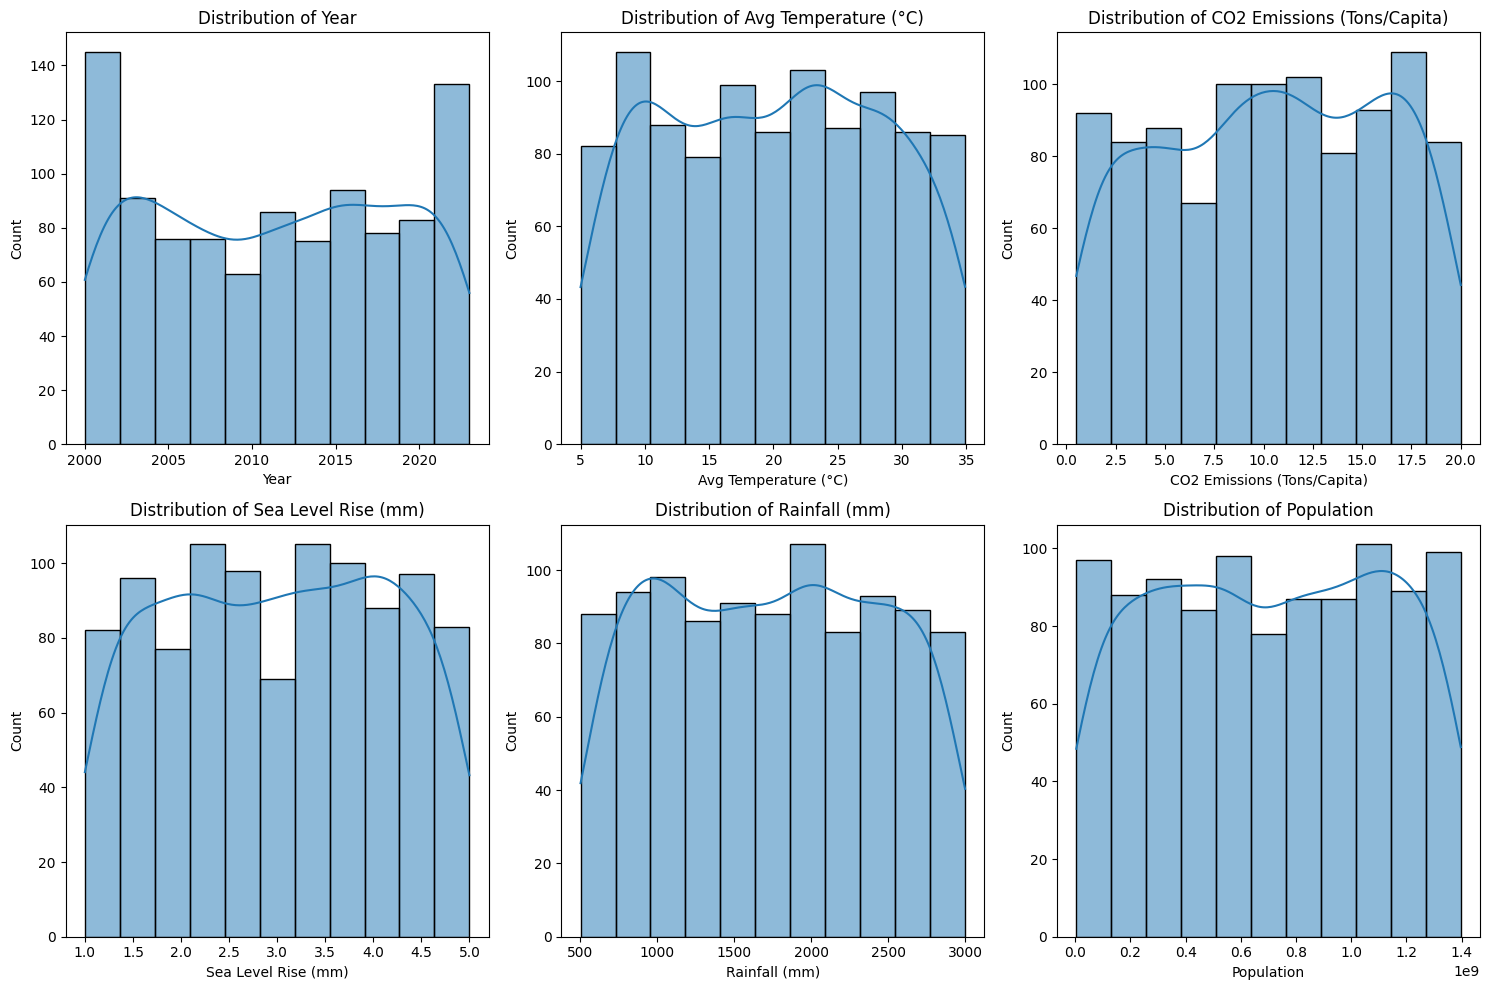

In [33]:
# Distribution of Numeric Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:6]):  # Show first 6 to avoid clutter
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

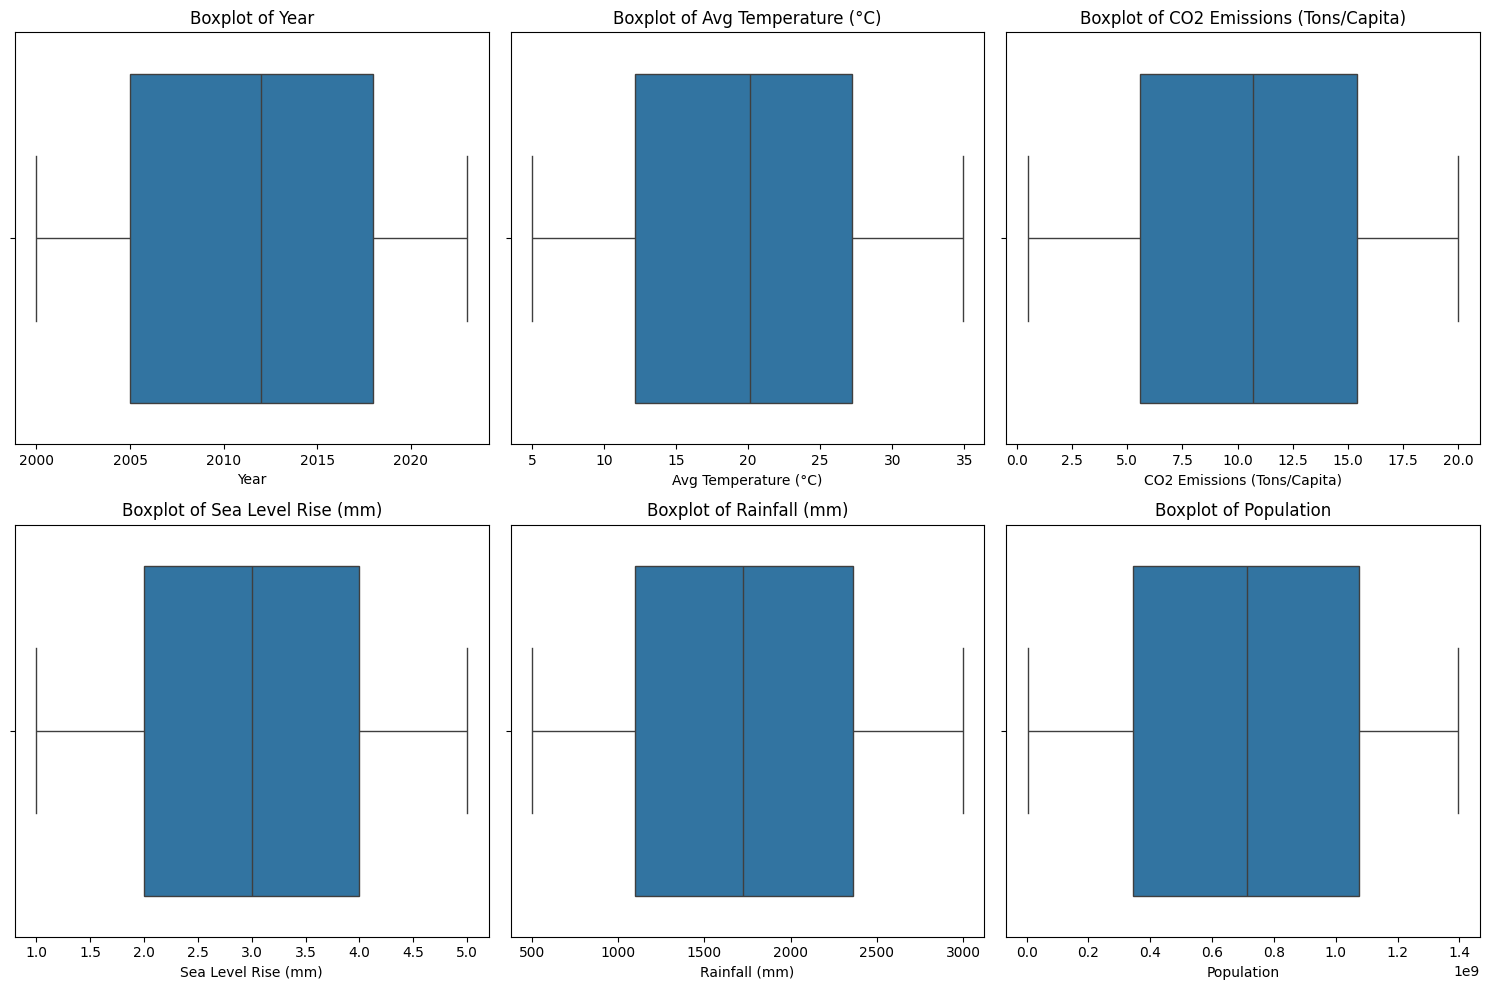

In [34]:
#  Boxplots to detect outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

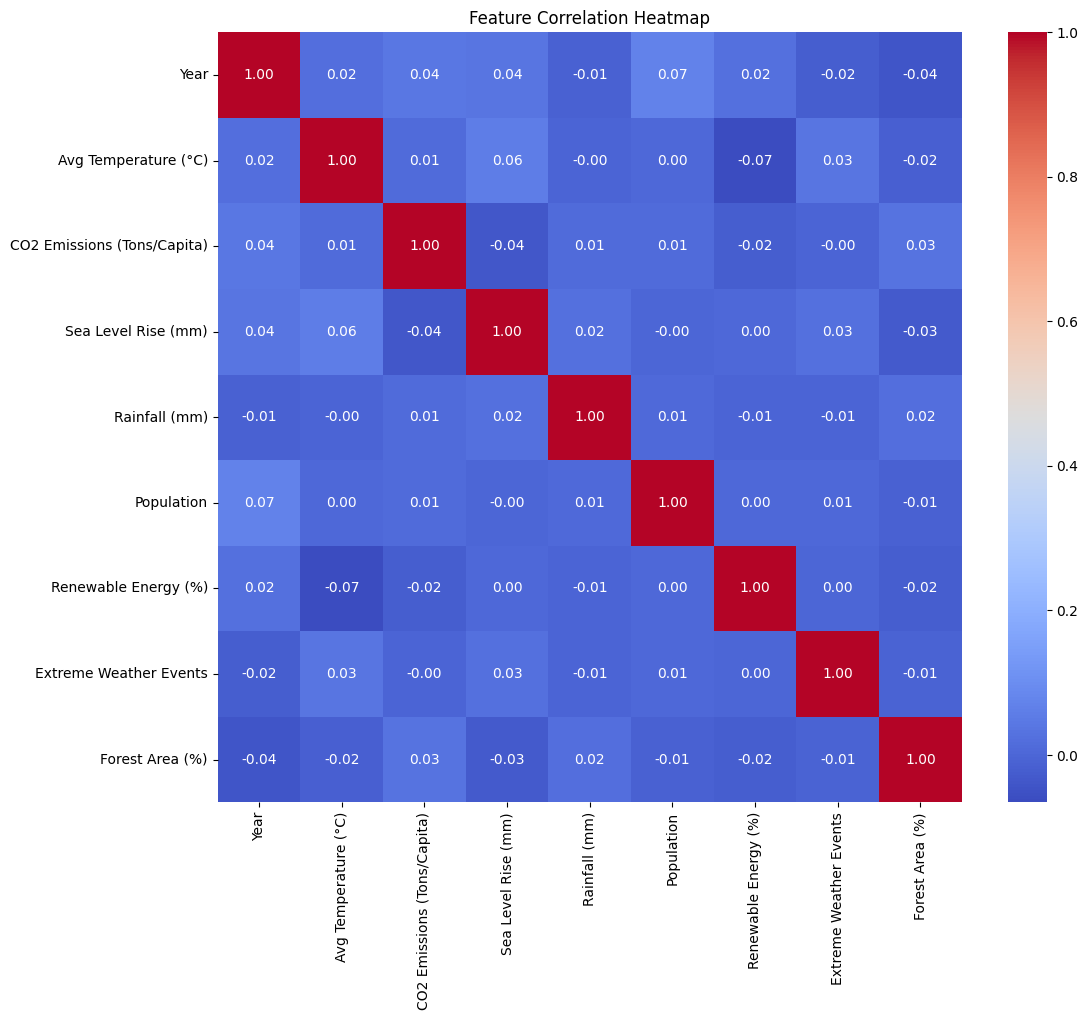

In [35]:
#  Correlation Matrix
corr_data = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(corr_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

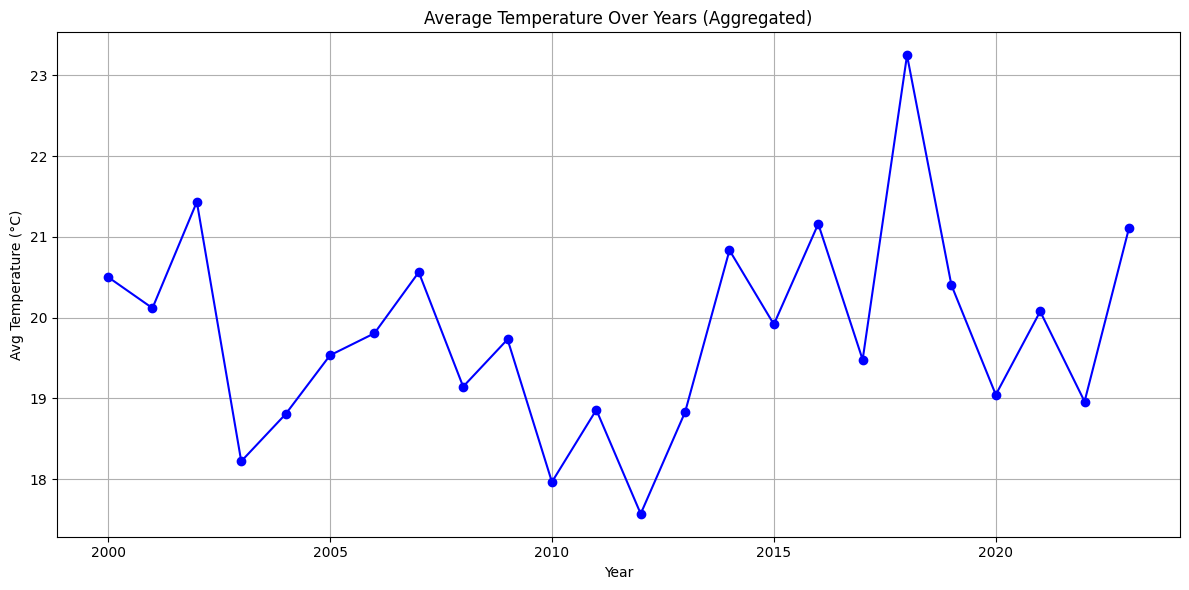

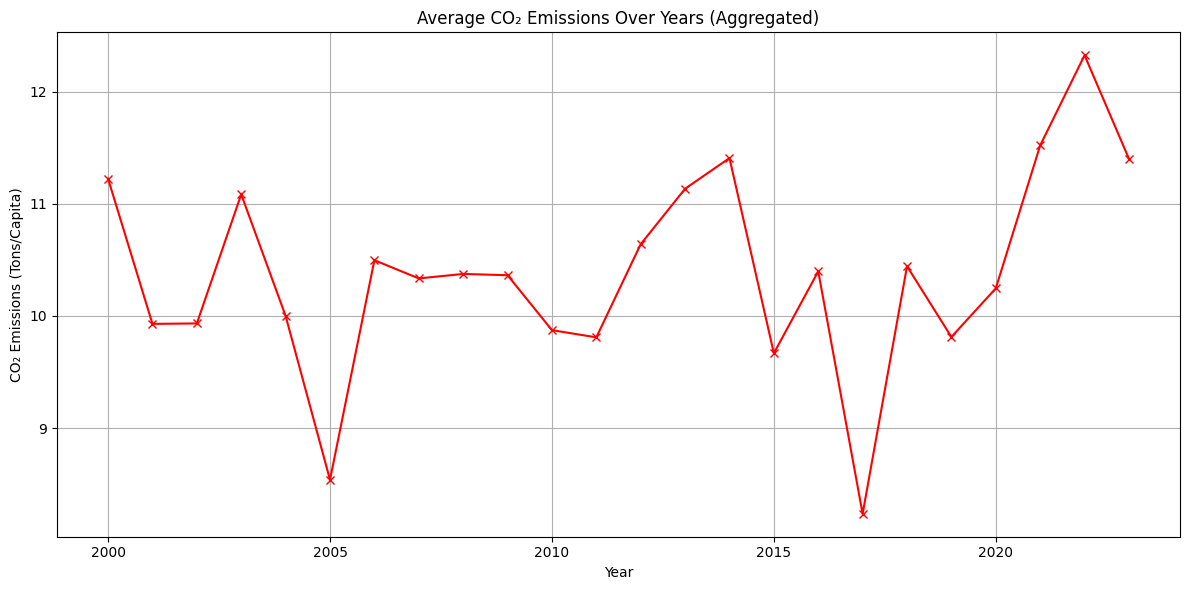

In [38]:
# Group by Year and calculate average
yearly_avg = df.groupby('Year').agg({
    'Avg Temperature (°C)': 'mean',
    'CO2 Emissions (Tons/Capita)': 'mean'
}).reset_index()

# Plot Average Temperature Over Years
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['Year'], yearly_avg['Avg Temperature (°C)'], marker='o', color='blue')
plt.title("Average Temperature Over Years (Aggregated)")
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot CO₂ Emissions Over Years
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['Year'], yearly_avg['CO2 Emissions (Tons/Capita)'], marker='x', color='red')
plt.title("Average CO₂ Emissions Over Years (Aggregated)")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions (Tons/Capita)")
plt.grid(True)
plt.tight_layout()
plt.show()


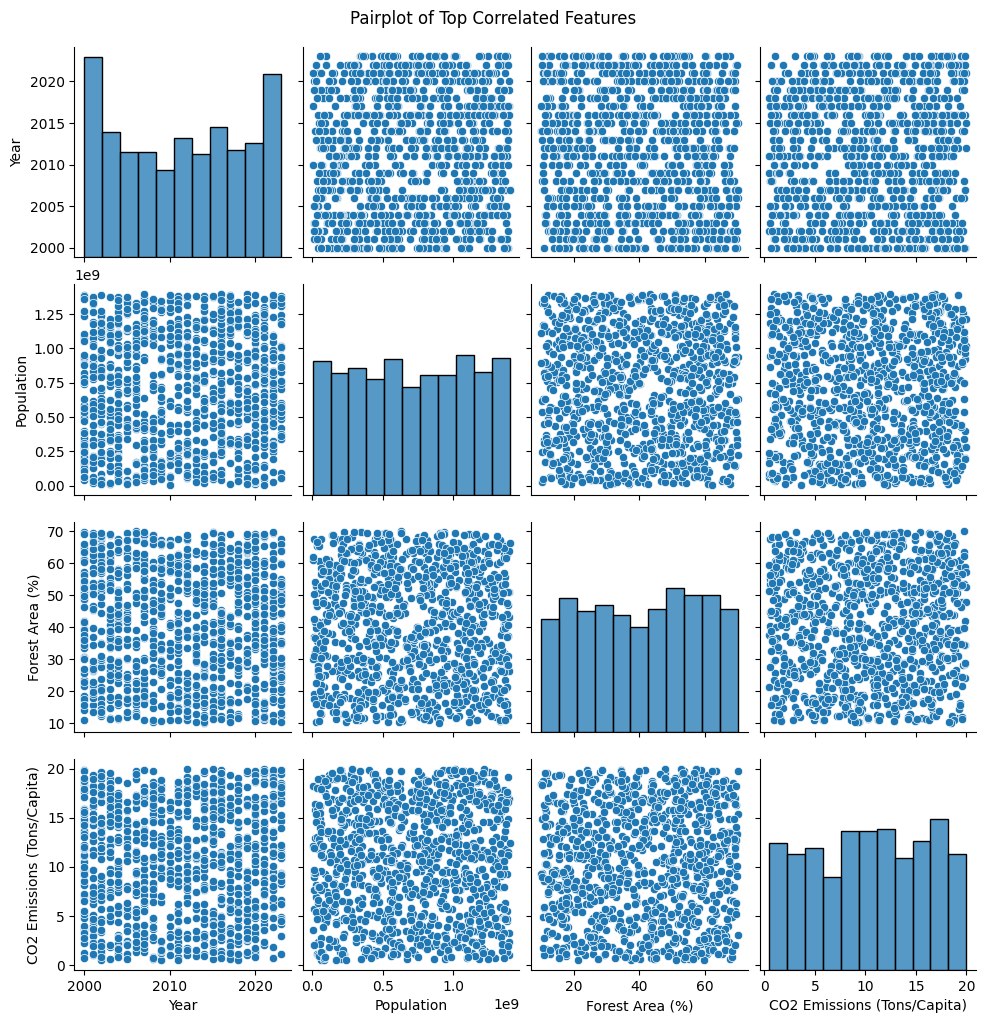

In [40]:
# --- Identify relationships (pairplot of top correlated features) ---
top_corr = corr_data.corr().abs().iloc[:, 0].sort_values(ascending=False).head(4).index.tolist()

sns.pairplot(df[top_corr].dropna())
plt.suptitle("Pairplot of Top Correlated Features", y=1.02)
plt.show()

## Data Preprocessing

In [41]:
# --- Separate features and target ---
target = 'Avg Temperature (°C)'  # Replace with actual target
y = df[target]
X = df.drop(columns=[target])


In [42]:
# --- Identify column types ---
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [43]:
# --- Preprocessing for numeric data ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardize
])

In [44]:
# --- Preprocessing for categorical data ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode
])

In [45]:
# --- Combine preprocessing steps ---
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [46]:
# --- Create complete preprocessing + modeling pipeline if needed ---
# from sklearn.ensemble import RandomForestRegressor
# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor())
# ])

# --- Apply preprocessing only ---
X_processed = preprocessor.fit_transform(X)

# --- Train-test split (80% train, 20% test) ---
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Optional: further split training data into train/validation
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Shapes after preprocessing:")
print("Train:", X_train_final.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Shapes after preprocessing:
Train: (640, 23)
Validation: (160, 23)
Test: (200, 23)


##Feature Engineering

In [121]:
from sklearn.feature_selection import SelectKBest, f_regression
# Sort by Country and Year to make time-series features consistent
df = df.sort_values(['Country', 'Year'])

In [122]:
# Feature Engineering: Rolling average & lagged variables per Country
grouped = df.groupby('Country')


In [123]:
# Create rolling averages (window=3) and lagged variables (lag=1) for numeric features
numeric_cols = ['Avg Temperature (°C)', 'CO2 Emissions (Tons/Capita)', 'Sea Level Rise (mm)',
                'Rainfall (mm)', 'Population', 'Renewable Energy (%)', 'Forest Area (%)']

for col in numeric_cols:
    # Rolling average grouped by Country
    df[f'{col}_rolling_avg_3'] = df.groupby('Country')[col].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
    # Lagged variable (shift by 1 year)
    df[f'{col}_lag_1'] = df.groupby('Country')[col].shift(1)


In [124]:
# Drop rows with NaNs caused by lag (optional)
df = df.dropna()

In [125]:
# Define features and target
feature_cols = [col for col in df.columns if col not in ['Year', 'Country', 'CO2 Emissions (Tons/Capita)']]
X = df[feature_cols]
y = df['CO2 Emissions (Tons/Capita)']

In [126]:
# Scale features before feature selection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [127]:
# Feature selection using ANOVA F-value (for regression-like target)
selector = SelectKBest(score_func=f_regression, k=5)
X_selected = selector.fit_transform(X_scaled, y)

In [128]:
# Get selected feature names
selected_features = X.columns[selector.get_support()]

print("Selected features:", selected_features.tolist())

Selected features: ['Sea Level Rise (mm)', 'CO2 Emissions (Tons/Capita)_rolling_avg_3', 'CO2 Emissions (Tons/Capita)_lag_1', 'Sea Level Rise (mm)_lag_1', 'Renewable Energy (%)_rolling_avg_3']


## Feature Engineering & Feature Selection (for Classification)

In [53]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

In [54]:
# Sort to ensure time consistency
df = df.sort_values(['Country', 'Year'])

# Columns to engineer features from
numeric_cols = ['Avg Temperature (°C)', 'CO2 Emissions (Tons/Capita)', 'Sea Level Rise (mm)',
                'Rainfall (mm)', 'Population', 'Renewable Energy (%)', 'Forest Area (%)']


In [55]:
# Create rolling averages and lag features grouped by Country
for col in numeric_cols:
    df[f'{col}_rolling_avg_3'] = df.groupby('Country')[col].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
    df[f'{col}_lag_1'] = df.groupby('Country')[col].shift(1)


In [56]:
# Drop rows with missing values from lagging
df = df.dropna()

In [133]:
# Define features and target
X = df.drop(columns=['Year', 'Country', 'Extreme Weather Events'])  # Drop identifiers and target
y = df['Extreme Weather Events']

In [136]:
# Feature selection for classification
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected = selector.fit_transform(X, y)

In [137]:
# Get selected feature names
selected_feature_names = X.columns[selector.get_support()]
print("Selected Features:", selected_feature_names.tolist())

Selected Features: ['Avg Temperature (°C)', 'Sea Level Rise (mm)', 'Population', 'Avg Temperature (°C)_rolling_avg_3', 'Avg Temperature (°C)_lag_1', 'CO2 Emissions (Tons/Capita)_rolling_avg_3', 'Sea Level Rise (mm)_rolling_avg_3', 'Renewable Energy (%)_lag_1', 'Extreme_Encoded', 'Avg Temperature (°C)_lag1']


# Visualize Top 10 Feature Importances

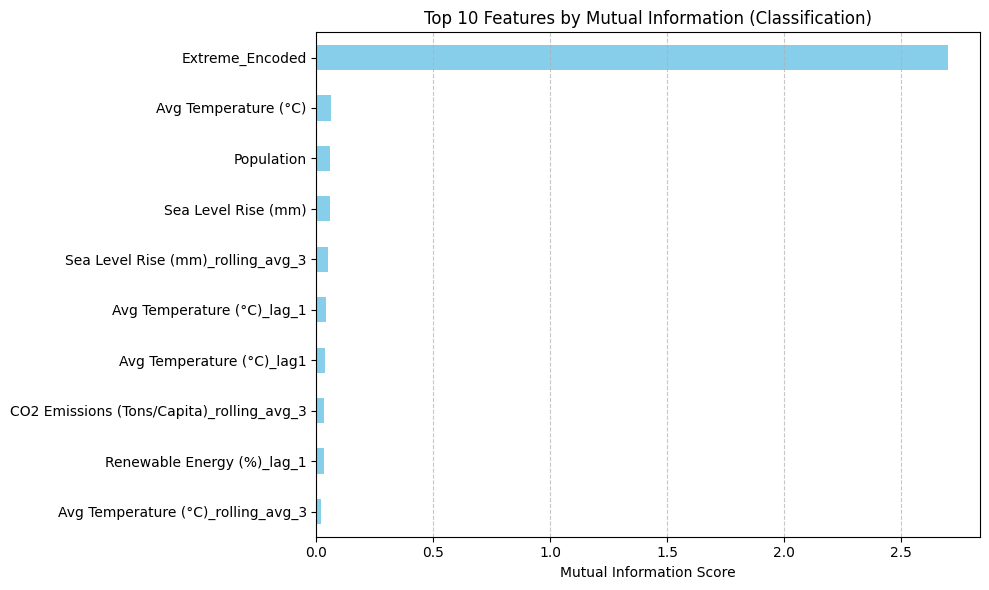

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Assuming df is preprocessed and cleaned as before
# And contains the necessary rolling and lagged features

# Drop identifier and target columns
X = df.drop(columns=['Year', 'Country', 'Extreme Weather Events'])
y = df['Extreme Weather Events']

# Compute mutual information scores for all features
mi_scores = mutual_info_classif(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=X.columns)

# Sort scores in descending order and select top 10
top_10_mi = mi_series.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
top_10_mi.plot(kind='barh', color='skyblue')
plt.xlabel('Mutual Information Score')
plt.title('Top 10 Features by Mutual Information (Classification)')
plt.gca().invert_yaxis()  # Highest at the top
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Model Selection and traning

In [151]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor  # ✅ This line fixes the error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [147]:
# Fix this by replacing LogisticRegression with LinearRegression
from sklearn.linear_model import LinearRegression
models["Linear Regression"] = LinearRegression()


In [148]:
# Fix: increase max_iter and scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-fit models that need scaled data
models["Neural Network"] = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)


In [150]:
from xgboost import XGBRegressor
models["XGBoost"] = XGBRegressor(objective='reg:squarederror', random_state=42)


In [154]:
# Scale the data (important for NN and gradient-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "Neural Network (MLP)": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}



In [153]:
# Train and evaluate
results = {}
for name, model in models.items():
    if name in ["Neural Network (MLP)", "Linear Regression", "Gradient Boosting", "XGBoost"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {'MSE': mse, 'R2': r2}

# Show results
for model, scores in results.items():
    print(f"{model}: MSE = {scores['MSE']:.2f}, R² = {scores['R2']:.2f}")

Linear Regression: MSE = 0.00, R² = 1.00
Decision Tree: MSE = 0.00, R² = 1.00
Random Forest: MSE = 0.00, R² = 1.00
Gradient Boosting: MSE = 0.00, R² = 1.00
XGBoost: MSE = 0.00, R² = 1.00
Neural Network (MLP): MSE = 0.26, R² = 0.99


## LSTM for Time Series

In [155]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [158]:
# Example: Use only one country's data (e.g., United States)
# Example: Use only one country's data (e.g., United States)
country_name = 'United States' # Define the country name

# Check unique country names in the DataFrame
print("Unique countries in DataFrame:", df['Country'].unique())

# Filter the DataFrame for the specific country
country_df = df[df['Country'] == country_name].copy()

# Check if the filtered DataFrame is empty
if country_df.empty:
    print(f"Error: No data found for country '{country_name}'. Please check the country name spelling or if data exists.")
else:
    print(f"Data found for {country_name}. Shape: {country_df.shape}")
    features = country_df.drop(columns=['Year', 'Country', 'Extreme Weather Events']).values
    target = country_df['Extreme Weather Events'].values

Unique countries in DataFrame: ['Argentina' 'Australia' 'Brazil' 'Canada' 'China' 'France' 'Germany'
 'India' 'Indonesia' 'Japan' 'Mexico' 'Russia' 'South Africa' 'UK' 'USA']
Error: No data found for country 'United States'. Please check the country name spelling or if data exists.


In [166]:
country_df = df[df['Country'] == 'United States']
print(country_df.shape)


(0, 26)


In [175]:
country_df = df[df['Country'] == 'USA'].copy()


In [176]:
# Check if any data exists
if country_df.empty:
    print("No data for 'USA'. Please check the dataset.")
else:
    features = country_df.drop(columns=['Year', 'Country', 'Extreme Weather Events']).values
    target = country_df['Extreme Weather Events'].values


In [177]:
    # Scale features
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)


In [178]:
    # Create sequences
    def create_sequences(X, y, time_steps=3):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:i+time_steps])
            ys.append(y[i+time_steps])
        return np.array(Xs), np.array(ys)

    X_seq, y_seq = create_sequences(features_scaled, target)

In [179]:
    # Train-test split
    split = int(0.8 * len(X_seq))
    X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
    y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

In [180]:
    # LSTM Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense

    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=4, validation_split=0.2)

    from sklearn.metrics import mean_squared_error, r2_score
    lstm_preds = model.predict(X_test_seq)
    lstm_mse = mean_squared_error(y_test_seq, lstm_preds)
    lstm_r2 = r2_score(y_test_seq, lstm_preds)
    print(f"LSTM: MSE = {lstm_mse:.2f}, R² = {lstm_r2:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 78.8556 - val_loss: 51.0993
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 54.3192 - val_loss: 40.2572
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 52.0221 - val_loss: 21.8706
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 26.8628 - val_loss: 27.5248
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 32.0401 - val_loss: 20.4115
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25.2751 - val_loss: 19.7459
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 27.4452 - val_loss: 19.6167
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.4625 - val_loss: 20.8342
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 20.3744 - val_loss: 19.6269
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 24.3687 - val_loss: 20.5896
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.1624 - val_loss: 19.3380
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
LSTM: MSE = 22.12, R² = -0.17


#Best Performing one from multiple model

In [183]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Step 1: Prepare data (non-sequential for this part)
X = df[[
    'Avg Temperature (°C)', 'CO2 Emissions (Tons/Capita)', 'Sea Level Rise (mm)',
    'Rainfall (mm)', 'Population', 'Renewable Energy (%)', 'Forest Area (%)'
]]
y = df['Extreme Weather Events']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Step 4: Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name}: MSE = {mse:.2f}, R² = {r2:.2f}")

# Step 5: Identify best
best_model = min(results, key=lambda x: results[x]['MSE'])
print(f"\n✅ Best model based on lowest MSE: {best_model}")


Linear Regression: MSE = 19.87, R² = -0.03
Decision Tree: MSE = 33.17, R² = -0.71
Random Forest: MSE = 20.92, R² = -0.08
Gradient Boosting: MSE = 20.64, R² = -0.06
XGBoost: MSE = 25.22, R² = -0.30

✅ Best model based on lowest MSE: Linear Regression


##Model Evaluation

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [188]:
# Define model
model = RandomForestRegressor(random_state=42)

# K-Fold Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Predictions using cross_val_predict (for plotting)
y_pred_cv = cross_val_predict(model, X_rf, y_seq, cv=cv)

# Metrics using cross_val_score
mae = -cross_val_score(model, X_rf, y_seq, cv=cv, scoring='neg_mean_absolute_error').mean()
mse = -cross_val_score(model, X_rf, y_seq, cv=cv, scoring='neg_mean_squared_error').mean()
r2 = cross_val_score(model, X_rf, y_seq, cv=cv, scoring='r2').mean()

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Absolute Error (MAE): 4.1508
Mean Squared Error (MSE): 22.9804
R-squared (R²): -0.2621


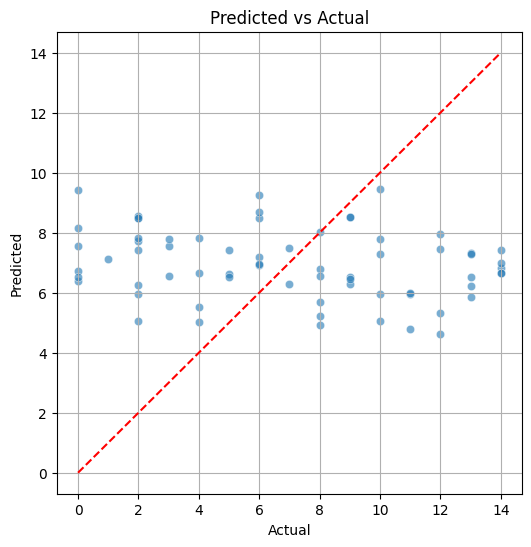

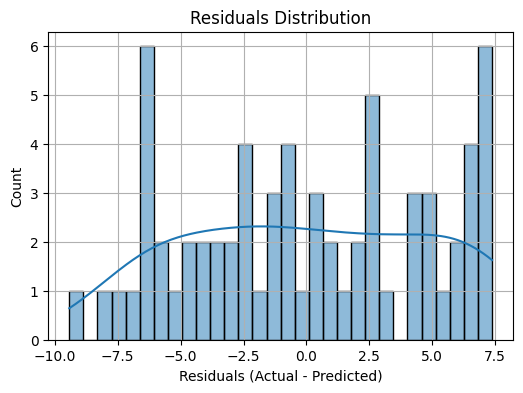

In [191]:
# Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_seq, y=y_pred_cv, alpha=0.6)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.plot([y_seq.min(), y_seq.max()], [y_seq.min(), y_seq.max()], 'r--')  # 45-degree line
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_seq - y_pred_cv
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


## Future Projections

##Future Projections Using Trained LSTM Model

In [251]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [252]:
# Load and preprocess data
df = df.drop(columns=['Country', 'Extreme Weather Events'])  # Remove non-numeric

# Fill missing values (optional)
df = df.fillna(method='ffill')


<ipython-input-252-ad3a0dd1fcde>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [253]:
# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame for easier indexing
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)


In [254]:
# Create sequences
def create_sequences(data, target_column, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].drop(columns=[target_column]).values
        target = data.iloc[i+seq_length][target_column]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# Set sequence length and target
seq_length = 10
target_col = 'Avg Temperature (°C)'
X, y = create_sequences(scaled_df, target_column=target_col, seq_length=seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [255]:
# Build LSTM moel
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2]), activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0871 - val_loss: 0.0817
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0903 - val_loss: 0.0813
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0832 - val_loss: 0.0812
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0881 - val_loss: 0.0951
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0829 - val_loss: 0.0812
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0825 - val_loss: 0.0818
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0799 - val_loss: 0.0820
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0855 - val_loss: 0.0822
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0803 - val_loss: 0.0821
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0785 - val_loss: 0.0813
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0790 - val_loss: 0.0819
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0782 - va

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,781 (264.77 KB)

 Trainable params: 22,593 (88.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,188 (176.52 KB)

In [256]:
import numpy as np

def make_future_lstm_projections(model, last_sequence, steps_ahead, scaler, df_columns, target_column):
    """
    Generate future projections using trained LSTM model.

    last_sequence: np.array, shape (1, timesteps, features)
    steps_ahead: int, number of future steps
    scaler: trained MinMaxScaler
    df_columns: list of all columns
    target_column: str, name of target to extract from inverse scale
    """
    predictions = []
    current_input = last_sequence.copy()

    for _ in range(steps_ahead):
        pred = model.predict(current_input, verbose=0)[0, 0]
        predictions.append(pred)

        # Replace the target column in the last step with the predicted value
        new_timestep = current_input[0, -1, :].copy()
        target_idx = df_columns.index(target_column)
        new_timestep[target_idx] = pred

        # Create next input sequence
        new_seq = np.vstack([current_input[0, 1:], new_timestep])
        current_input = np.expand_dims(new_seq, axis=0)

    # Inverse transform
    padded_preds = np.zeros((len(predictions), len(df_columns)))
    padded_preds[:, target_idx] = predictions
    unscaled = scaler.inverse_transform(padded_preds)[:, target_idx]
    return unscaled



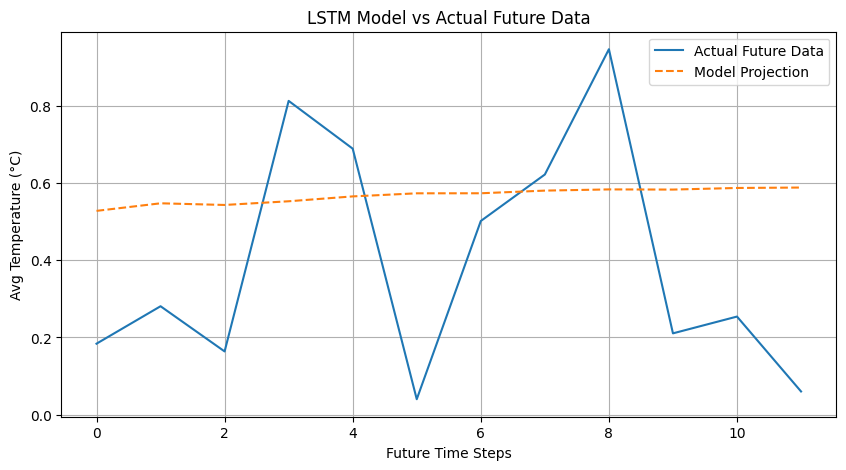

In [257]:
# Validation against Ground Truth
# Create prediction input
X_last = X[-1:]  # last sequence from your dataset

# Predict 12 future steps
future_preds = make_future_lstm_projections(
    model=model,
    last_sequence=X_last,
    steps_ahead=12,
    scaler=scaler,
    df_columns=df.columns.tolist(),
    target_column='Avg Temperature (°C)'
)

# Optional: Compare with known actual values (if available)
# Let's assume your dataset continues with 12 real future values after the training data
real_future = df['Avg Temperature (°C)'].values[-12:]

# Plot comparison
plt.figure(figsize=(10, 5))
plt.plot(range(12), real_future, label='Actual Future Data')
plt.plot(range(12), future_preds, label='Model Projection', linestyle='--')
plt.title('LSTM Model vs Actual Future Data')
plt.xlabel('Future Time Steps')
plt.ylabel('Avg Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


In [260]:
#Evaluation Metrics (Optional Validation)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(real_future, future_preds)
mse = mean_squared_error(real_future, future_preds)
r2 = r2_score(real_future, future_preds)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R² Score: {r2:.3f}")


MAE: 0.301
MSE: 0.114
R² Score: -0.327


##Scenario Analysis

# Define Scenario

In [261]:
def simulate_scenario(model, base_sequence, steps_ahead, scaler, df_columns, target_column, scenario_func):
    """
    Simulate a scenario where input features (e.g., CO2) are adjusted over time.

    scenario_func: function to apply to input sequence per time step (e.g., increase CO2)
    """
    target_idx = df_columns.index(target_column)
    sequence = base_sequence.copy()
    predictions = []

    for step in range(steps_ahead):
        # Predict next step
        pred = model.predict(sequence, verbose=0)[0, 0]
        predictions.append(pred)

        # Modify features using the scenario function
        last_step = sequence[0, -1, :].copy()
        last_step[target_idx] = pred
        last_step = scenario_func(last_step, step)  # Apply scenario modification

        # Update input sequence
        next_seq = np.vstack([sequence[0, 1:], last_step])
        sequence = np.expand_dims(next_seq, axis=0)

    # Inverse transform
    padded_preds = np.zeros((len(predictions), len(df_columns)))
    padded_preds[:, target_idx] = predictions
    unscaled_preds = scaler.inverse_transform(padded_preds)[:, target_idx]

    return unscaled_preds


## Define Scenarios (Example: CO2 Up, CO2 Down, No Change)

In [262]:
# Scenario functions
def scenario_high_co2(timestep, step):
    # Simulate rising CO2: +1% each future step
    co2_idx = df.columns.get_loc('CO2 Emissions (Tons/Capita)')
    timestep[co2_idx] *= (1 + 0.01 * step)
    return timestep

def scenario_low_co2(timestep, step):
    # Simulate decreasing CO2: -1% each future step
    co2_idx = df.columns.get_loc('CO2 Emissions (Tons/Capita)')
    timestep[co2_idx] *= (1 - 0.01 * step)
    return timestep

def scenario_stable_co2(timestep, step):
    # No change in CO2
    return timestep


## Run Scenarios and Plot

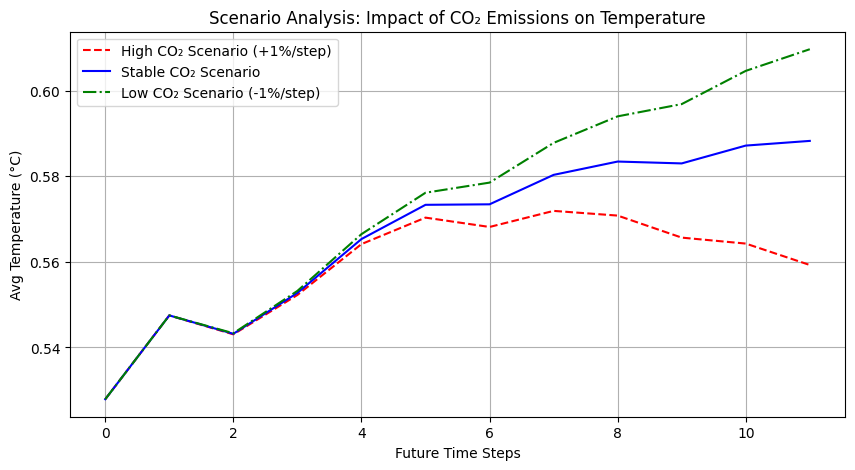

In [263]:
# Use last sequence for simulation
X_last = X[-1:]

# Predict
steps = 12
pred_high = simulate_scenario(model, X_last, steps, scaler, df.columns.tolist(), 'Avg Temperature (°C)', scenario_high_co2)
pred_low = simulate_scenario(model, X_last, steps, scaler, df.columns.tolist(), 'Avg Temperature (°C)', scenario_low_co2)
pred_stable = simulate_scenario(model, X_last, steps, scaler, df.columns.tolist(), 'Avg Temperature (°C)', scenario_stable_co2)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(steps), pred_high, label='High CO₂ Scenario (+1%/step)', linestyle='--', color='red')
plt.plot(range(steps), pred_stable, label='Stable CO₂ Scenario', linestyle='-', color='blue')
plt.plot(range(steps), pred_low, label='Low CO₂ Scenario (-1%/step)', linestyle='-.', color='green')
plt.xlabel("Future Time Steps")
plt.ylabel("Avg Temperature (°C)")
plt.title("Scenario Analysis: Impact of CO₂ Emissions on Temperature")
plt.legend()
plt.grid(True)
plt.show()
